# **Predict Categories**

Advanced Topics in Machine Learning - Group P1_C

Produced by:
- Catarina Monteiro up202105279
- Diogo Mendes up202108102
- Gonçalo Brochado up202106090

This notebook introduces a comprehensive categorization framework for abstracts, aimed at significantly streamlining the search process. To predict categories effectively, we will explore multiple approaches, including classification based on both the title and abstract, as well as an analysis using only the title. By comparing these strategies, we can identify the most effective method for accurate categorization, ultimately enhancing the discoverability and retrieval of relevant scientific papers in the dataset. This systematic approach will provide valuable insights into the relationship between titles, abstracts, and their associated categories, optimizing the search experience for users.

## **Dependencies**

In [1]:
!pip install datasets
!pip install evaluate
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=

## **Libraries**

In [2]:
import torch
#from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
import evaluate
from itertools import chain
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from transformers import pipeline

## **Data**

The data for the project was retrieved using the Hugging Face datasets library, specifically loading the Arxiv abstracts dataset. This dataset includes metadata from scientific papers, such as titles, abstracts, author names, and categories, and provides a comprehensive base for training and evaluating models for title generation, abstract generation, and category prediction.

In [3]:
ds = load_dataset("gfissore/arxiv-abstracts-2021")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.75k [00:00<?, ?B/s]

arxiv-abstracts.jsonl.gz:   0%|          | 0.00/940M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1999486 [00:00<?, ? examples/s]

In [ ]:
ds['train'].column_names

['id',
 'submitter',
 'authors',
 'title',
 'comments',
 'journal-ref',
 'doi',
 'abstract',
 'report-no',
 'categories',
 'versions']

In [ ]:
cat = ds['train']['categories']

In [ ]:
cat_unique = set(chain(*cat)) #Categories of each paper (One paper can have more than 1 category)

In [ ]:
cat_unique

{'math.SG math.CA math.CV',
 'physics.geo-ph astro-ph gr-qc physics.space-ph',
 'math.AG hep-th math.CT math.RT',
 'cond-mat.mes-hall cond-mat.stat-mech physics.plasm-ph quant-ph',
 'physics.bio-ph cond-mat.stat-mech stat.AP',
 'physics.data-an astro-ph.IM hep-ex nucl-ex stat.AP stat.ME',
 'math.GN cs.DM math.CO',
 'q-bio.MN cs.LG q-bio.GN',
 'physics.bio-ph cs.CV physics.data-an q-bio.SC',
 'math.SG math.AG math.GT math.RT',
 'cond-mat.stat-mech cond-mat.dis-nn cond-mat.mtrl-sci nlin.PS',
 'physics.bio-ph cond-mat.soft hep-lat nlin.AO q-bio',
 'solv-int chao-dyn gr-qc nlin.CD nlin.SI',
 'physics.data-an cond-mat.mes-hall cond-mat.stat-mech',
 'cs.SE',
 'math.NA math-ph math.FA math.MP',
 'cond-mat.mtrl-sci nucl-ex',
 'physics.hist-ph nucl-ex',
 'q-fin.TR q-fin.PM q-fin.RM',
 'math.DG math.CA math.CV',
 'math.DG math.AT math.MG math.OC',
 'cond-mat.str-el cond-mat.stat-mech math-ph math.CV math.MP math.SP',
 'cs.IT math.CO math.IT quant-ph',
 'stat.CO cs.NE physics.data-an',
 'nlin.PS 

In [ ]:
cat_unique_final = set() # Separate in parts/categories 

for c in cat_unique:
    cat_unique_final.update(c.split(" "))

In [ ]:
cat_unique_final

{'acc-phys',
 'adap-org',
 'alg-geom',
 'ao-sci',
 'astro-ph',
 'astro-ph.CO',
 'astro-ph.EP',
 'astro-ph.GA',
 'astro-ph.HE',
 'astro-ph.IM',
 'astro-ph.SR',
 'atom-ph',
 'bayes-an',
 'chao-dyn',
 'chem-ph',
 'cmp-lg',
 'comp-gas',
 'cond-mat',
 'cond-mat.dis-nn',
 'cond-mat.mes-hall',
 'cond-mat.mtrl-sci',
 'cond-mat.other',
 'cond-mat.quant-gas',
 'cond-mat.soft',
 'cond-mat.stat-mech',
 'cond-mat.str-el',
 'cond-mat.supr-con',
 'cs.AI',
 'cs.AR',
 'cs.CC',
 'cs.CE',
 'cs.CG',
 'cs.CL',
 'cs.CR',
 'cs.CV',
 'cs.CY',
 'cs.DB',
 'cs.DC',
 'cs.DL',
 'cs.DM',
 'cs.DS',
 'cs.ET',
 'cs.FL',
 'cs.GL',
 'cs.GR',
 'cs.GT',
 'cs.HC',
 'cs.IR',
 'cs.IT',
 'cs.LG',
 'cs.LO',
 'cs.MA',
 'cs.MM',
 'cs.MS',
 'cs.NA',
 'cs.NE',
 'cs.NI',
 'cs.OH',
 'cs.OS',
 'cs.PF',
 'cs.PL',
 'cs.RO',
 'cs.SC',
 'cs.SD',
 'cs.SE',
 'cs.SI',
 'cs.SY',
 'dg-ga',
 'econ.EM',
 'econ.GN',
 'econ.TH',
 'eess.AS',
 'eess.IV',
 'eess.SP',
 'eess.SY',
 'funct-an',
 'gr-qc',
 'hep-ex',
 'hep-lat',
 'hep-ph',
 'hep-th',
 'm

In [4]:
#created based on the Arxiv data

categorias_hier = {
    "cs.AI": "Artificial Intelligence",
    "cs.AR": "Hardware Architecture",
    "cs.CC": "Computational Complexity",
    "cs.CE": "Computational Engineering, Finance, and Science",
    "cs.CG": "Computational Geometry",
    "cs.CL": "Computation and Language",
    "cs.CR": "Cryptography and Security",
    "cs.CV": "Computer Vision and Pattern Recognition",
    "cs.CY": "Computers and Society",
    "cs.DB": "Databases",
    "cs.DC": "Distributed, Parallel, and Cluster Computing",
    "cs.DL": "Digital Libraries",
    "cs.DM": "Discrete Mathematics",
    "cs.DS": "Data Structures and Algorithms",
    "cs.ET": "Emerging Technologies",
    "cs.FL": "Formal Languages and Automata Theory",
    "cs.GL": "General Literature",
    "cs.GR": "Graphics",
    "cs.GT": "Computer Science and Game Theory",
    "cs.HC": "Human-Computer Interaction",
    "cs.IR": "Information Retrieval",
    "cs.IT": "Information Theory",
    "cs.LG": "Machine Learning",
    "cs.LO": "Logic in Computer Science",
    "cs.MA": "Multiagent Systems",
    "cs.MM": "Multimedia",
    "cs.MS": "Mathematical Software",
    "cs.NA": "Numerical Analysis",
    "cs.NE": "Neural and Evolutionary Computing",
    "cs.NI": "Networking and Internet Architecture",
    "cs.OH": "Other Computer Science",
    "cs.OS": "Operating Systems",
    "cs.PF": "Performance",
    "cs.PL": "Programming Languages",
    "cs.RO": "Robotics",
    "cs.SC": "Symbolic Computation",
    "cs.SD": "Sound",
    "cs.SE": "Software Engineering",
    "cs.SI": "Social and Information Networks",
    "cs.SY": "Systems and Control",
    "econ.EM": "Econometrics",
    "econ.GN": "General Economics",
    "econ.TH": "Theoretical Economics",
    "eess.AS": "Audio and Speech Processing",
    "eess.IV": "Image and Video Processing",
    "eess.SP": "Signal Processing",
    "eess.SY": "Systems and Control",
    "math.AC": "Commutative Algebra",
    "math.AG": "Algebraic Geometry",
    "math.AP": "Analysis of PDEs",
    "math.AT": "Algebraic Topology",
    "math.CA": "Classical Analysis and ODEs",
    "math.CO": "Combinatorics",
    "math.CT": "Category Theory",
    "math.CV": "Complex Variables",
    "math.DG": "Differential Geometry",
    "math.DS": "Dynamical Systems",
    "math.FA": "Functional Analysis",
    "math.GM": "General Mathematics",
    "math.GN": "General Topology",
    "math.GR": "Group Theory",
    "math.GT": "Geometric Topology",
    "math.HO": "History and Overview",
    "math.IT": "Information Theory",
    "math.KT": "K-Theory and Homology",
    "math.LO": "Logic",
    "math.MG": "Metric Geometry",
    "math.MP": "Mathematical Physics",
    "math.NA": "Numerical Analysis",
    "math.NT": "Number Theory",
    "math.OA": "Operator Algebras",
    "math.OC": "Optimization and Control",
    "math.PR": "Probability",
    "math.QA": "Quantum Algebra",
    "math.RA": "Rings and Algebras",
    "math.RT": "Representation Theory",
    "math.SG": "Symplectic Geometry",
    "math.SP": "Spectral Theory",
    "math.ST": "Statistics Theory",
    "astro-ph.CO": "Cosmology and Nongalactic Astrophysics",
    "astro-ph.EP": "Earth and Planetary Astrophysics",
    "astro-ph.GA": "Astrophysics of Galaxies",
    "astro-ph.HE": "High Energy Astrophysical Phenomena",
    "astro-ph.IM": "Instrumentation and Methods for Astrophysics",
    "astro-ph.SR": "Solar and Stellar Astrophysics",
    "cond-mat.dis-nn": "Disordered Systems and Neural Networks",
    "cond-mat.mes-hall": "Mesoscale and Nanoscale Physics",
    "cond-mat.mtrl-sci": "Materials Science",
    "cond-mat.other": "Other Condensed Matter",
    "cond-mat.quant-gas": "Quantum Gases",
    "cond-mat.soft": "Soft Condensed Matter",
    "cond-mat.stat-mech": "Statistical Mechanics",
    "cond-mat.str-el": "Strongly Correlated Electrons",
    "cond-mat.supr-con": "Superconductivity",
    "gr-qc": "General Relativity and Quantum Cosmology",
    "hep-ex": "High Energy Physics - Experiment",
    "hep-lat": "High Energy Physics - Lattice",
    "hep-ph": "High Energy Physics - Phenomenology",
    "hep-th": "High Energy Physics - Theory",
    "math-ph": "Mathematical Physics",
    "nlin.AO": "Adaptation and Self-Organizing Systems",
    "nlin.CD": "Chaotic Dynamics",
    "nlin.CG": "Cellular Automata and Lattice Gases",
    "nlin.PS": "Pattern Formation and Solitons",
    "nlin.SI": "Exactly Solvable and Integrable Systems",
    "nucl-ex": "Nuclear Experiment",
    "nucl-th": "Nuclear Theory",
    "physics.acc-ph": "Accelerator Physics",
    "physics.ao-ph": "Atmospheric and Oceanic Physics",
    "physics.app-ph": "Applied Physics",
    "physics.atm-clus": "Atomic and Molecular Clusters",
    "physics.atom-ph": "Atomic Physics",
    "physics.bio-ph": "Biological Physics",
    "physics.chem-ph": "Chemical Physics",
    "physics.class-ph": "Classical Physics",
    "physics.comp-ph": "Computational Physics",
    "physics.data-an": "Data Analysis, Statistics and Probability",
    "physics.ed-ph": "Physics Education",
    "physics.flu-dyn": "Fluid Dynamics",
    "physics.gen-ph": "General Physics",
    "physics.geo-ph": "Geophysics",
    "physics.hist-ph": "History and Philosophy of Physics",
    "physics.ins-det": "Instrumentation and Detectors",
    "physics.med-ph": "Medical Physics",
    "physics.optics": "Optics",
    "physics.plasm-ph": "Plasma Physics",
    "physics.pop-ph": "Popular Physics",
    "physics.soc-ph": "Physics and Society",
    "physics.space-ph": "Space Physics",
    "quant-ph": "Quantum Physics",
    "q-bio.BM": "Biomolecules",
    "q-bio.CB": "Cell Behavior",
    "q-bio.GN": "Genomics",
    "q-bio.MN": "Molecular Networks",
    "q-bio.NC": "Neurons and Cognition",
    "q-bio.OT": "Other Quantitative Biology",
    "q-bio.PE": "Populations and Evolution",
    "q-bio.QM": "Quantitative Methods",
    "q-bio.SC": "Subcellular Processes",
    "q-bio.TO": "Tissues and Organs",
    "q-fin.CP": "Computational Finance",
    "q-fin.EC": "Economics",
    "q-fin.GN": "General Finance",
    "q-fin.MF": "Mathematical Finance",
    "q-fin.PM": "Portfolio Management",
    "q-fin.PR": "Pricing of Securities",
    "q-fin.RM": "Risk Management",
    "q-fin.ST": "Statistical Finance",
    "q-fin.TR": "Trading and Market Microstructure",
    "stat.AP": "Applications",
    "stat.CO": "Computation",
    "stat.ME": "Methodology",
    "stat.ML": "Machine Learning",
    "stat.OT": "Other Statistics",
    "stat.TH": "Statistics Theory"
}

In [ ]:
print("Categorias existentes no Arxiv: " + str(len(categorias_hier)))
print("Categorias existentes no dataset: " + str(len(cat_unique_final)))

Categorias existentes no Arxiv: 155
Categorias existentes no dataset: 176


In [ ]:
# Comparison between the dictionary created from the data on the arXiv website and the data collected from the dataset

dict_keys = set(categorias_hier.keys())

extra_in_set = cat_unique_final - dict_keys

print("Chaves no conjunto que não estão no dicionário:", extra_in_set)

Chaves no conjunto que não estão no dicionário: {'acc-phys', 'ao-sci', 'bayes-an', 'alg-geom', 'dg-ga', 'solv-int', 'cond-mat', 'patt-sol', 'supr-con', 'comp-gas', 'funct-an', 'cmp-lg', 'mtrl-th', 'adap-org', 'q-bio', 'astro-ph', 'chao-dyn', 'plasm-ph', 'q-alg', 'chem-ph', 'atom-ph'}


Among these categories, we have some that are general, such as q-bio, which are not an issue, and others, like bayes-an, which are not found in the arXiv data. We consider these to be outdated nomenclatures, and since they are few, we will ignore them.

## **Taxonomy**

Category 1/2:
 - Computer Science (cs)
 - Economics (econ)
 - Electrical Engineering and Systems Science (eess)
 - Mathematics (math)
 - Physics {
      - Astrophysics (astro-ph)
      - Condensed Matter (cond-mat)
      - General Relativity and Quantum Cosmology (gr-qc)
      - High Energy Physics (hep)
      - Mathematical Physics (math-ph)
      - Nonlinear Sciences (nlin)
      - Nuclear Experiment (nucl)
      - Physics (physics)
      - Quantum Physics (quant-ph)
 }
 - Quantitative Biology (q-bio)
 - Quantitative Finance (q-fin)
 - Statistics (stat)

### Hierarchical tree image

In [5]:
#Created based on Arxiv data

categorias_hier2 = {"Computer Science": {
                            "cs.AI": "Artificial Intelligence",
                            "cs.AR": "Hardware Architecture",
                            "cs.CC": "Computational Complexity",
                            "cs.CE": "Computational Engineering, Finance, and Science",
                            "cs.CG": "Computational Geometry",
                            "cs.CL": "Computation and Language",
                            "cs.CR": "Cryptography and Security",
                            "cs.CV": "Computer Vision and Pattern Recognition",
                            "cs.CY": "Computers and Society",
                            "cs.DB": "Databases",
                            "cs.DC": "Distributed, Parallel, and Cluster Computing",
                            "cs.DL": "Digital Libraries",
                            "cs.DM": "Discrete Mathematics",
                            "cs.DS": "Data Structures and Algorithms",
                            "cs.ET": "Emerging Technologies",
                            "cs.FL": "Formal Languages and Automata Theory",
                            "cs.GL": "General Literature",
                            "cs.GR": "Graphics",
                            "cs.GT": "Computer Science and Game Theory",
                            "cs.HC": "Human-Computer Interaction",
                            "cs.IR": "Information Retrieval",
                            "cs.IT": "Information Theory",
                            "cs.LG": "Machine Learning",
                            "cs.LO": "Logic in Computer Science",
                            "cs.MA": "Multiagent Systems",
                            "cs.MM": "Multimedia",
                            "cs.MS": "Mathematical Software",
                            "cs.NA": "Numerical Analysis",
                            "cs.NE": "Neural and Evolutionary Computing",
                            "cs.NI": "Networking and Internet Architecture",
                            "cs.OH": "Other Computer Science",
                            "cs.OS": "Operating Systems",
                            "cs.PF": "Performance",
                            "cs.PL": "Programming Languages",
                            "cs.RO": "Robotics",
                            "cs.SC": "Symbolic Computation",
                            "cs.SD": "Sound",
                            "cs.SE": "Software Engineering",
                            "cs.SI": "Social and Information Networks",
                            "cs.SY": "Systems and Control"
                    },
                    "Economics": {
                            "econ.EM": "Econometrics",
                            "econ.GN": "General Economics",
                            "econ.TH": "Theoretical Economics"
                    },
                    "Electrical Engineering and Systems Science": {
                            "eess.AS": "Audio and Speech Processing",
                            "eess.IV": "Image and Video Processing",
                            "eess.SP": "Signal Processing",
                            "eess.SY": "Systems and Control"
                    },
                    "Mathematics": {
                            "math.AC": "Commutative Algebra",
                            "math.AG": "Algebraic Geometry",
                            "math.AP": "Analysis of PDEs",
                            "math.AT": "Algebraic Topology",
                            "math.CA": "Classical Analysis and ODEs",
                            "math.CO": "Combinatorics",
                            "math.CT": "Category Theory",
                            "math.CV": "Complex Variables",
                            "math.DG": "Differential Geometry",
                            "math.DS": "Dynamical Systems",
                            "math.FA": "Functional Analysis",
                            "math.GM": "General Mathematics",
                            "math.GN": "General Topology",
                            "math.GR": "Group Theory",
                            "math.GT": "Geometric Topology",
                            "math.HO": "History and Overview",
                            "math.IT": "Information Theory",
                            "math.KT": "K-Theory and Homology",
                            "math.LO": "Logic",
                            "math.MG": "Metric Geometry",
                            "math.MP": "Mathematical Physics",
                            "math.NA": "Numerical Analysis",
                            "math.NT": "Number Theory",
                            "math.OA": "Operator Algebras",
                            "math.OC": "Optimization and Control",
                            "math.PR": "Probability",
                            "math.QA": "Quantum Algebra",
                            "math.RA": "Rings and Algebras",
                            "math.RT": "Representation Theory",
                            "math.SG": "Symplectic Geometry",
                            "math.SP": "Spectral Theory",
                            "math.ST": "Statistics Theory"
                    },
                    "Physics": {
                            "Astrophysics": {
                                "astro-ph.CO": "Cosmology and Nongalactic Astrophysics",
                                "astro-ph.EP": "Earth and Planetary Astrophysics",
                                "astro-ph.GA": "Astrophysics of Galaxies",
                                "astro-ph.HE": "High Energy Astrophysical Phenomena",
                                "astro-ph.IM": "Instrumentation and Methods for Astrophysics",
                                "astro-ph.SR": "Solar and Stellar Astrophysics"
                            },
                            "Condensed Matter":{
                                "cond-mat.dis-nn": "Disordered Systems and Neural Networks",
                                "cond-mat.mes-hall": "Mesoscale and Nanoscale Physics",
                                "cond-mat.mtrl-sci": "Materials Science",
                                "cond-mat.other": "Other Condensed Matter",
                                "cond-mat.quant-gas": "Quantum Gases",
                                "cond-mat.soft": "Soft Condensed Matter",
                                "cond-mat.stat-mech": "Statistical Mechanics",
                                "cond-mat.str-el": "Strongly Correlated Electrons",
                                "cond-mat.supr-con": "Superconductivity"
                            },
                            "General Relativity and Quantum Cosmology": {
                                "gr-qc": "General Relativity and Quantum Cosmology"
                            },
                            "High Energy Physics": {
                                "hep-ex": "High Energy Physics - Experiment",
                                "hep-lat": "High Energy Physics - Lattice",
                                "hep-ph": "High Energy Physics - Phenomenology",
                                "hep-th": "High Energy Physics - Theory"
                            },
                            "Mathematical Physics":{
                                "math-ph": "Mathematical Physics"
                            },
                            "Nonlinear Sciences":{
                                "nlin.AO": "Adaptation and Self-Organizing Systems",
                                "nlin.CD": "Chaotic Dynamics",
                                "nlin.CG": "Cellular Automata and Lattice Gases",
                                "nlin.PS": "Pattern Formation and Solitons",
                                "nlin.SI": "Exactly Solvable and Integrable Systems"
                            },
                            "Nuclear Experiment":{
                                "nucl-ex": "Nuclear Experiment",
                                "nucl-th": "Nuclear Theory"
                            },
                            "Physics":{
                                "physics.acc-ph": "Accelerator Physics",
                                "physics.ao-ph": "Atmospheric and Oceanic Physics",
                                "physics.app-ph": "Applied Physics",
                                "physics.atm-clus": "Atomic and Molecular Clusters",
                                "physics.atom-ph": "Atomic Physics",
                                "physics.bio-ph": "Biological Physics",
                                "physics.chem-ph": "Chemical Physics",
                                "physics.class-ph": "Classical Physics",
                                "physics.comp-ph": "Computational Physics",
                                "physics.data-an": "Data Analysis, Statistics and Probability",
                                "physics.ed-ph": "Physics Education",
                                "physics.flu-dyn": "Fluid Dynamics",
                                "physics.gen-ph": "General Physics",
                                "physics.geo-ph": "Geophysics",
                                "physics.hist-ph": "History and Philosophy of Physics",
                                "physics.ins-det": "Instrumentation and Detectors",
                                "physics.med-ph": "Medical Physics",
                                "physics.optics": "Optics",
                                "physics.plasm-ph": "Plasma Physics",
                                "physics.pop-ph": "Popular Physics",
                                "physics.soc-ph": "Physics and Society",
                                "physics.space-ph": "Space Physics"
                            },
                            "Quantum Physics":{
                                "quant-ph": "Quantum Physics"
                            },
                    },
                    "Quantitative Biology": {
                            "q-bio.BM": "Biomolecules",
                            "q-bio.CB": "Cell Behavior",
                            "q-bio.GN": "Genomics",
                            "q-bio.MN": "Molecular Networks",
                            "q-bio.NC": "Neurons and Cognition",
                            "q-bio.OT": "Other Quantitative Biology",
                            "q-bio.PE": "Populations and Evolution",
                            "q-bio.QM": "Quantitative Methods",
                            "q-bio.SC": "Subcellular Processes",
                            "q-bio.TO": "Tissues and Organs"
                    },
                    "Quantitative Finance": {
                            "q-fin.CP": "Computational Finance",
                            "q-fin.EC": "Economics",
                            "q-fin.GN": "General Finance",
                            "q-fin.MF": "Mathematical Finance",
                            "q-fin.PM": "Portfolio Management",
                            "q-fin.PR": "Pricing of Securities",
                            "q-fin.RM": "Risk Management",
                            "q-fin.ST": "Statistical Finance",
                            "q-fin.TR": "Trading and Market Microstructure"
                    },
                    "Statistics": {
                            "stat.AP": "Applications",
                            "stat.CO": "Computation",
                            "stat.ME": "Methodology",
                            "stat.ML": "Machine Learning",
                            "stat.OT": "Other Statistics",
                            "stat.TH": "Statistics Theory"
                    }
}




## **Model comparison test**

**Tested Models**:
- BERT
- facebook/bart-large-mnli
- Wi/arxiv-topics-distilbert-base-cased
- Yozhikoff/arxiv-topics-distilbert-base-cased
- Llama 3.2 - 1B Instruct

(*The models were tested manually with 2/3 examples for the most dificult task of predict without hierarchy*)

#### Facebook/bart-large-mnli

In [6]:
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli",
                      device=0)


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
sequence_to_classify = """Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies. A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with data from the Fermilab Tevatron, and predictions are made for\nmore detailed tests with CDF and DO data. Predictions are shown for\ndistributions of diphoton pairs produced at the energy of the Large Hadron\nCollider (LHC). Distributions of the diphoton pairs from the decay of a Higgs\nboson are contrasted with those produced from QCD processes at the LHC, showing\nthat enhanced sensitivity to the signal can be obtained with judicious\nselection of events.\n"""
candidate_labels = list(categorias_hier.values())
classifier(sequence_to_classify, candidate_labels, multi_label=True)


{'sequence': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies. A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with data from the Fermilab Tevatron, and predictions are made for\nmore detailed tests with CDF and DO data. Predictions are shown for\ndistributions of diphoton pairs produced at the energy of the Large Hadron\nCollider (LHC). Distributions of the diphoton pairs from the decay of a Higgs\nboson are contrasted with those produced from QCD processes at the LHC, show

### **Test function without hierarchy**

In [ ]:
def teste_categories_ta(categorias_hier, ds, classifier):
  sum = 0
  n = 100 #number of tests
  true_labels = []
  pred_labels = []
  for i in range(n):
    title = ds['train'][i]['title']
    sequence_to_classify = title
    #abstract = ds['train'][i]['abstract']
    #sequence_to_classify = title + abstract
    candidate_labels = list(categorias_hier.values())
    label = classifier(sequence_to_classify, candidate_labels, multi_label=True)['labels']
    label = label[:5]
    #print(label)

    cate = ds['train'][i]['categories']
    cate = cate[0].split(" ")
    #print(cate)

    cate_ext = []
    for j in cate:
      try:
        cate_ext.append(categorias_hier[j])
      except:
        pass

    true_labels.append(cate_ext)
    pred_labels.append(label)

    sum += comparar(cate_ext, label)
    print(i)

  flat_true_labels = [1 if label in cate_ext else 0 for label in candidate_labels for cate_ext in true_labels]
  flat_pred_labels = [1 if label in label_pred else 0 for label in candidate_labels for label_pred in pred_labels]
  f1 = f1_score(flat_true_labels, flat_pred_labels)
  return sum/n , f1

def comparar(cate_ext, label):
  count = 0
  if len(cate_ext) == 0:
    return 100
  for i in cate_ext:
    if i in label:
      count += 1
  return count*100/len(cate_ext)

In [ ]:
# Test with title and abstract with 20 examples
accuracy_cat_ta, f1_cat_ta = teste_categories_ta(categorias_hier, ds, classifier)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
print(accuracy_cat_ta)
print(f1_cat_ta)

27.5
0.064


In [ ]:
#Test with title with 20 examples
accuracy_cat_t, f1_cat_t = teste_categories_ta(categorias_hier, ds, classifier)

0
1
2
3
4
5
6
7
8


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


9
10
11
12
13
14
15
16
17
18
19


In [ ]:
print(accuracy_cat_t)
print(f1_cat_t)

35.0
0.0967741935483871


In [ ]:
#Test with title with 100 examples
accuracy_cat_t_100, f1_cat_t_100 = teste_categories_ta(categorias_hier, ds, classifier)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
print(accuracy_cat_t_100)
print(f1_cat_t_100)

24.033333333333335
0.07878787878787878


### **Test function with hierarchy**

In [ ]:
def teste_categories_hierarquia_ta(categorias_hier2, ds, classifier):
  sum = 0
  n = 100 #Numero de testes
  true_labels = []
  pred_labels = []
  for i in range(n):
    title = ds['train'][i]['title']
    sequence_to_classify = title
    #abstract = ds['train'][i]['abstract']
    #sequence_to_classify = title + abstract
    candidate_labels = list(categorias_hier2.keys())
    label = classifier(sequence_to_classify, candidate_labels, multi_label=True)['labels']
    label = label[:1]
    #print(label)

    # Second part of hierarchy except Physics
    if label[0] != "Physics":
      candidate_labels = list(categorias_hier2[label[0]].values())
      label = classifier(sequence_to_classify, candidate_labels, multi_label=True)['labels']
      label = label[:5]
      #print(label)

    else:
      candidate_labels = list(categorias_hier2[label[0]].keys())
      label_ant = label[0]
      label = classifier(sequence_to_classify, candidate_labels, multi_label=True)['labels']
      label = label[:1]
      if label[0] == "General Relativity and Quantum Cosmology" or label[0] == "High Energy Physics" or label[0] == "Quantum Physics" or  label[0] == "Nuclear Experiment" or label[0] == "Mathematical Physics":
        candidate_labels = list(categorias_hier2[label_ant][label[0]].keys())
        label = classifier(sequence_to_classify, candidate_labels, multi_label=True)['labels']
        label = label[:1]
      else:
        candidate_labels = list(categorias_hier2[label_ant][label[0]].keys())
        label = classifier(sequence_to_classify, candidate_labels, multi_label=True)['labels']
        label = label[:5]

    #print(label)


    cate = ds['train'][i]['categories']
    cate = cate[0].split(" ")
    #print(cate)

    cate_ext = []
    for j in cate:
      try:
        cate_ext.append(categorias_hier[j])
      except:
        pass

    true_labels.append(cate_ext)
    pred_labels.append(label)

    sum += comparar(cate_ext, label)
    print(i)


  flat_true_labels = [1 if label in cate_ext else 0 for label in candidate_labels for cate_ext in true_labels]
  flat_pred_labels = [1 if label in label_pred else 0 for label in candidate_labels for label_pred in pred_labels]
  f1 = f1_score(flat_true_labels, flat_pred_labels)
  return sum/n , f1

def comparar(cate_ext, label):
  count = 0
  if len(cate_ext) == 0:
    return 100
  for i in cate_ext:
    if i in label:
      count += 1
  return count*100/len(cate_ext)

In [ ]:
#Test with hierarchy with 100 examples
accuracy_cat_hier_t, f1_cat_hier_t = teste_categories_hierarquia_ta(categorias_hier, ds, classifier)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
print(accuracy_cat_hier_t)
print(f1_cat_hier_t)

16.2
0.0


### **Test function with hierarchy only with the main category**

In [10]:
def teste_hieraquia_mae(categorias_hier2, ds, classifier):
  sum = 0
  n = 100 #number of tests
  true_labels = []
  pred_labels = []
  for i in range(n):
    title = ds['train'][i]['title']
    sequence_to_classify = title
    candidate_labels = list(categorias_hier2.keys())
    label = classifier(sequence_to_classify, candidate_labels, multi_label=True)['labels']
    label = label[0]

    cate = ds['train'][i]['categories']
    cate = cate[0].split(" ")

    re = categoria_mae(cate, categorias_hier2)

    if re == label:
      sum += 100
    else:
      sum += 0

  return sum/n


def categoria_mae(cate, hierarquia):
    # Dictionary to count the number of occurencies by principle category
    contagem_categorias = {}

    # Percorrer a lista de códigos
    for codigo in lista_codigos:
        for categoria_principal, subcategorias in hierarquia.items():
            # Check if a main category have subcategories or is a nested dictionary
            if isinstance(subcategorias, dict):
                if codigo in subcategorias:
                    # Increments the counting for the main category
                    contagem_categorias[categoria_principal] = contagem_categorias.get(categoria_principal, 0) + 1
                    break

    # Find the main category with higher count
    categoria_mais_frequente = max(contagem_categorias, key=contagem_categorias.get)
    return categoria_mais_frequente

In [11]:
#Test with hierarchy with 100 examples
accuracy_cat_hier2_t = teste_hieraquia_mae(categorias_hier2, ds, classifier)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [12]:
print(accuracy_cat_hier2_t)


44.0


## **Results**

Although we initially tested different models manually with 2-3 examples, we concluded that some Hugging Face models, supposedly trained for this task, contain different categories, which did not aid in this process. We identified the best model for testing as facebook/bart-large-mnli, a model trained specifically for classification.

We tested various types of models. Although we initially proposed using Encoder-only models for this task, we also tested others, including Llama3.2 1B Instruct, a Decoder-only model, primarily because it is an "Instruct" model designed for various tasks, potentially yielding interesting results. However, this was not the case.

### **Title+Abstract vs Title**

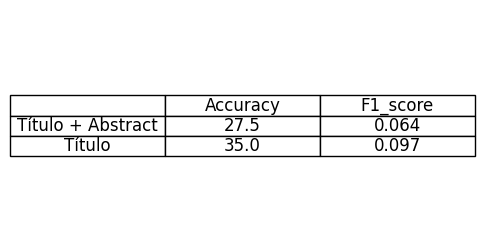

In [ ]:
data = [
    ["", "Accuracy", "F1_score"],  
    ["Título + Abstract", 27.5, 0.064],
    ["Título", 35.0, 0.097]
]

fig, ax = plt.subplots(figsize=(5, 3))
ax.axis("off")  

table = ax.table(cellText=data, loc="center", cellLoc="center", colLoc="center")

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

plt.show()


We only tested with 20 examples. We decided to use this value because predicting using both the title and abstract takes approximately 13 seconds for each example, whereas using only the title takes about 4 seconds.

By using just the title, we achieved better classification results and improvements in timing. Therefore, we will only use the title for classification.

### **Flat Distribution vs Hierarchical Distribution**

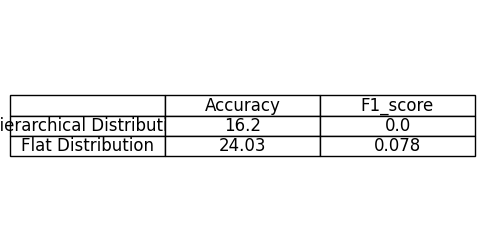

In [ ]:
data = [
    ["", "Accuracy", "F1_score"],  
    ["Hierarchical Distribution", 16.2, 0.0],
    ["Flat Distribution", 24.03, 0.078]
]

fig, ax = plt.subplots(figsize=(5, 3))
ax.axis("off")  

table = ax.table(cellText=data, loc="center", cellLoc="center", colLoc="center")

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

plt.show()


For this evaluation, we used 100 examples for each distribution. From these results, we found that the Flat Distribution is more efficient in classification than the Hierarchical Distribution. However, the Hierarchical method is significantly faster than the Flat method.

These results are likely due to the fact that, as the Hierarchical method requires selecting a general hierarchy, it only classifies within some of the subsets of that hierarchy. In many cases, a paper can be classified into different subclasses belonging to parent classes.

Due to this, we conducted another test to see if the model can classify a paper accurately by only assigning it to a parent class in the hierarchy.

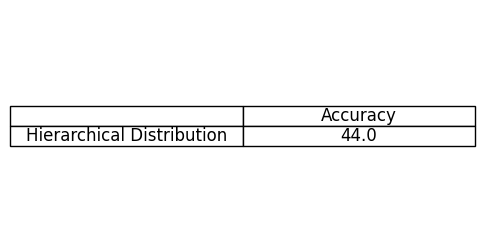

In [13]:
data = [
    ["", "Accuracy"],  
    ["Hierarchical Distribution", 44.0],
]

fig, ax = plt.subplots(figsize=(5, 3))
ax.axis("off")  

table = ax.table(cellText=data, loc="center", cellLoc="center", colLoc="center")

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

plt.show()


Although this value is not ideal and taking into account the complexity of the task, we consider the results to be good, especially since none of these tests involved fine-tuning the model for the specific task.